# QAOA and Adaptive QAOA
The notebook demonstrates the solution of a generic optimization problem using both the "vanilla" QAOA (Quantum Approximate Optimization Algorithm) and the Adaptive version

In [ ]:
import matplotlib.pyplot as plt

from classiq import *

### Hamiltonian encoding
The optimization objective function is encoded into a Hamiltonian function formulated as a weighted sum of Pauli strings:  
$$H = \sum_k{c_kP_k}$$

with each pauli string, $P_k$, composed of a Pauli operation ($\sigma\in\left\{I,X,Y,Z\right\}$) applied to each of the qubits in the register.

For example, $XIIZ$, applies a Pauli $X$ to the first qubit and a Pauli $Z$ to the fourth qubit

The encoding of the objective start by defining the function with binary variables, $x_i\in\left\{1,-1\right\}$, and then defining Pauli strings with $Z_i$ corresponding to the original variables. If the objective variables' domain is $x_i\in\left\{0,1\right\}$, a transformation is used: $x_i=\left(1-Z_i\right)/2$ (commonly referred to as _spin to bit_ transformation)  

Since the encoding results in Pauli strings composed only of $I$, and $Z$, the Pauli string is called _diagonal_, this has the following benefits:
* **Easy exponentiation** - the exponentiation results in simple to implement single or multi-qubit Z rotations
* **No superposition mixing** - the diagonal Hamiltonian does not create entanglement or rotate between basis states, enabling computation basis measurement
* **Efficient measurement** - all $\left\{I,Z\right\}^{\otimes n}$ strings commute, allowing for a single simultaneous measurement of all strings

#### QMod tip
In the following cell the variable `h` is set to a diagonal hamiltonian using a self explanatory syntax that sums sparse Pauli strings, that is only the non identity Paulis are specified. For example the first line, `- 0.1247375 * Pauli.Z(0) * Pauli.Z(1)` creates the string `ZZIII` with the weight `-0.1247375`. The length of the string, is inferred from the largest qubit index in the sum. The resulating variable has the type [SparsePauliOp](https://docs.classiq.io/latest/qmod-reference/api-reference/classical-types/?h=sparsepauliop#classiq.qmod.builtins.structs.SparsePauliOp)  

For the optimization function a _dual-use_ function is used for the Hamiltonian. This function takes a argument that can be either a `QArray` or a `list[int]`. This allows the same function to be used both to:
* compute the cost expectation on the measurement results which are binary numbers ($0,1$)
* create a quantum observable in the circuit, resulting in quantum gates

the additional `cost_func` function negates the `hamiltonian` function since the problem involves finding the maximum value, but the optimization procedure (`scipy.optimize.minimize`) performs a minimization

In [ ]:
from typing import Tuple

from sympy import sympify

from classiq.qmod.symbolic_expr import SymbolicExpr

QFloatExr = SymbolicExpr

h = (
    -0.1247375 * Pauli.Z(0) * Pauli.Z(1)
    - 0.1747375 * Pauli.Z(0)
    - 0.1207125 * Pauli.Z(1) * Pauli.Z(2)
    - 0.2954500 * Pauli.Z(1)
    - 0.1163000 * Pauli.Z(2) * Pauli.Z(3)
    - 0.2870125 * Pauli.Z(2)
    - 0.1247125 * Pauli.Z(3) * Pauli.Z(4)
    - 0.2910125 * Pauli.Z(3)
    - 0.1747125 * Pauli.Z(4)
    + 1.7093000 * Pauli.I(0)
)


def hamiltonian(v: QArray | list[int]) -> QFloatExr:
    single_weights = [-0.1747375, -0.29545, -0.2870125, -0.2910125, -0.1747125]
    nearest_neighbors_weights = [-0.1247375, -0.1207125, -0.1163, -0.1247125]

    def z_value(bit: int | QBit) -> QFloatExr:
        return sympify(1.0) - 2 * bit

    hamiltonian = sympify(1.7093)
    for i, w in enumerate(nearest_neighbors_weights):
        hamiltonian += w * z_value(v[i]) * z_value(v[i + 1])
    for i, w in enumerate(single_weights):
        hamiltonian += w * z_value(v[i])
    return hamiltonian


def cost_func(v: QArray | list[int]) -> QFloatExr:
    return -hamiltonian(v)  # negative sign for maximization

#### The Cost Layer
As mentioned above, since the Hamiltonian is diagonal, its exponentiation is straightforward and ammounts to phase addition due to Z rotations.  
This is accomplished with the [phase](https://docs.classiq.io/latest/qmod-reference/language-reference/statements/phase/?h=phase) function, which results in an efficient quantum implemetation of $e^{-i \gamma H_c}$

In [3]:
@qfunc
def cost_layer(gamma: CReal, v: QArray):
    phase(cost_func(v), gamma)

#### The Mixer Layer
The QAOA mixer is defined as $H_M=\sum{X_i}$, and its exponentiaion is simply a $R_X$ rotation of the same angle ($\beta$) on all the qubits

In [4]:
@qfunc
def mixer_layer(beta: CReal, qba: QArray):
    apply_to_all(lambda q: RX(2 * beta, q), qba)

#### The QAOA Ansatz
The parametric QAOA ansatz is composed of $p$ pairs of exponentiated Mixer and Cost Hamiltonians:  
$$U\left(\vec{\beta},\vec{\gamma}\right)=e^{-i \beta_p H_M}e^{-i \gamma_p H_C}\ldots e^{-i \beta_2 H_M}e^{-i \gamma_1 H_C}e^{-i \beta_2 H_M}e^{-i \gamma_1 H_C}$$

In [5]:
@qfunc
def qaoa_ansatz(
    gammas: CArray[CReal],
    betas: CArray[CReal],
    qba: QArray,
):
    n = gammas.len
    assert n == betas.len, "Number of gamma and beta parameters must be equal"
    for i in range(n):
        cost_layer(gammas[i], qba)
        mixer_layer(betas[i], qba)

### Assemble the full QAOA algorithm
We select $p=3$ layers for the QAOA. The quantum program takes the $2p$ parameters as a single list (because the `scipy.optimize.minimize` function manipulate a 1-D array of parameters), and the quantum register of the $5$ qubits.

The qubits are initialized to $\left|+\right\rangle^{\otimes 5}$, with a `hadamard_transform` and then the `qaoa_ansatz`, $U\left(\vec{\beta},\vec{\gamma}\right)$, is applied

In [6]:
from typing import Final

NUM_LAYERS: Final[int] = 3
NUM_QUBITS: Final[int] = 5


@qfunc
def main(
    params: CArray[
        CReal, NUM_LAYERS * 2  # type: ignore
    ],  # Execution parameters (first half: gammas, second half: betas)
    v: Output[QArray[QBit, NUM_QUBITS]],  # type: ignore
):
    allocate(v)
    hadamard_transform(v)
    gammas = params[0:NUM_LAYERS]
    betas = params[NUM_LAYERS : NUM_LAYERS * 2]

    qaoa_ansatz(gammas, betas, v)

In [ ]:
qprog = synthesize(main)

es = ExecutionSession(qprog)
show(qprog)

## Classical Optimization - "Vanilla" QAOA
the $\vec{\beta}$, and $\vec{\gamma}$ parameters are tuned until the objective function converges.

results of the parameters, and the solution vector are shown below

In [8]:
cost_trace = []
params_history = []


def objective_func(params):
    cost_estimation = es.estimate_cost(
        lambda state: cost_func(state["v"]), {"params": params.tolist()}
    )
    cost_trace.append(cost_estimation)
    params_history.append(params.copy())
    return cost_estimation

In [9]:
import numpy as np
import scipy
from tqdm import tqdm

MAX_ITERATIONS = 60

initial_params = np.concatenate(
    (np.linspace(0, 1, NUM_LAYERS), np.linspace(1, 0, NUM_LAYERS))
)

with tqdm(total=MAX_ITERATIONS, desc="Optimization Progress", leave=True) as pbar:

    def progress_bar(xk: np.ndarray) -> None:
        pbar.update(1)

    optimization_results = scipy.optimize.minimize(
        fun=objective_func,
        x0=initial_params,
        method="COBYLA",
        options={"maxiter": MAX_ITERATIONS},
        callback=progress_bar,
    )

# Sample the circuit using the optimized parameters
res = es.sample({"params": optimization_results.x.tolist()})
es.close()

print(f"Optimized parameters: {optimization_results.x.tolist()}")

Optimization Progress:  43%|████▎     | 26/60 [01:04<01:24,  2.50s/it]


Optimized parameters: [-0.13200533048244228, 1.5033108681979552, 0.9303607749202144, 1.9752193684116381, 0.4798598602090752, 0.10843038230378058]


Plotting the convergence graph: 

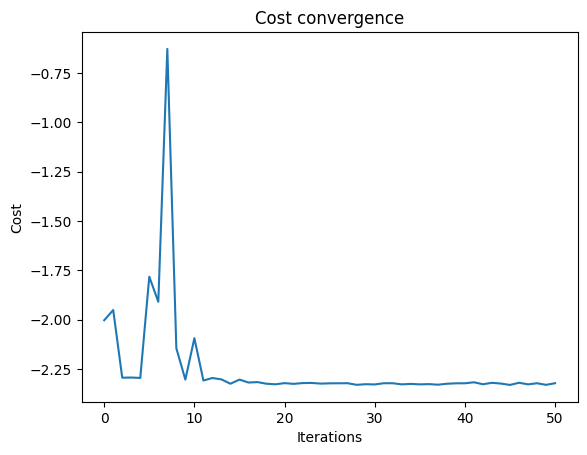

In [10]:
plt.plot(cost_trace)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Cost convergence")
plt.show()

## Displaying and Discussing the Results

In [11]:
print(f"Optimized parameters: {optimization_results.x.tolist()}")
sorted_counts = sorted(res.parsed_counts, key=lambda pc: cost_func(pc.state["v"]))
num_shots = sum(state.shots for state in res.parsed_counts)
for sampled in sorted_counts:
    solution = sampled.state["v"]
    probability = sampled.shots / num_shots
    cost_value = cost_func(solution)
    print(f"solution={solution} probability={probability:.3f} cost={cost_value:.3f}")

Optimized parameters: [-0.13200533048244228, 1.5033108681979552, 0.9303607749202144, 1.9752193684116381, 0.4798598602090752, 0.10843038230378058]
solution=[1, 1, 1, 1, 1] probability=0.264 cost=-2.446
solution=[1, 1, 1, 0, 1] probability=0.088 cost=-2.346
solution=[1, 1, 0, 1, 1] probability=0.069 cost=-2.346
solution=[0, 1, 1, 1, 1] probability=0.120 cost=-2.346
solution=[1, 1, 1, 1, 0] probability=0.110 cost=-2.346
solution=[1, 0, 1, 1, 1] probability=0.076 cost=-2.346
solution=[1, 0, 1, 1, 0] probability=0.047 cost=-2.246
solution=[0, 1, 1, 0, 1] probability=0.043 cost=-2.246
solution=[1, 1, 0, 1, 0] probability=0.037 cost=-2.246
solution=[0, 1, 0, 1, 1] probability=0.034 cost=-2.246
solution=[1, 0, 1, 0, 1] probability=0.026 cost=-2.246
solution=[0, 1, 1, 1, 0] probability=0.046 cost=-2.246
solution=[0, 1, 0, 1, 0] probability=0.017 cost=-2.146
solution=[1, 1, 0, 0, 1] probability=0.000 cost=-1.781
solution=[1, 1, 1, 0, 0] probability=0.001 cost=-1.747
solution=[0, 0, 1, 1, 1] prob

In [12]:
for idx in range(32):
    bits = list(int(bit) for bit in bin(idx)[2:])
    bits = [0] * (5 - len(bits)) + bits
    print(f"{bits=}, {hamiltonian(bits)=}")

bits=[0, 0, 0, 0, 0], hamiltonian(bits)=-8.74999999999626e-5
bits=[0, 0, 0, 0, 1], hamiltonian(bits)=0.598762500000000
bits=[0, 0, 0, 1, 0], hamiltonian(bits)=1.06396250000000
bits=[0, 0, 0, 1, 1], hamiltonian(bits)=1.16396250000000
bits=[0, 0, 1, 0, 0], hamiltonian(bits)=1.04796250000000
bits=[0, 0, 1, 0, 1], hamiltonian(bits)=1.64681250000000
bits=[0, 0, 1, 1, 0], hamiltonian(bits)=1.64681250000000
bits=[0, 0, 1, 1, 1], hamiltonian(bits)=1.74681250000000
bits=[0, 1, 0, 0, 0], hamiltonian(bits)=1.08171250000000
bits=[0, 1, 0, 0, 1], hamiltonian(bits)=1.68056250000000
bits=[0, 1, 0, 1, 0], hamiltonian(bits)=2.14576250000000
bits=[0, 1, 0, 1, 1], hamiltonian(bits)=2.24576250000000
bits=[0, 1, 1, 0, 0], hamiltonian(bits)=1.64691250000000
bits=[0, 1, 1, 0, 1], hamiltonian(bits)=2.24576250000000
bits=[0, 1, 1, 1, 0], hamiltonian(bits)=2.24576250000000
bits=[0, 1, 1, 1, 1], hamiltonian(bits)=2.34576250000000
bits=[1, 0, 0, 0, 0], hamiltonian(bits)=0.598862500000000
bits=[1, 0, 0, 0, 1], ham

# Adaptive QAOA
The algorithm, based on the paper [An adaptive quantum approximate optimization algorithm for solving combinatorial problems on a quantum computer](https://arxiv.org/pdf/2005.10258), modifies QAOA by using different _mixer_ layers, instead of the original $H_M=\sum_i{X_i}$

The algorithm defines a pool of potential mixer layers, that are simple to implement, and can match the problem better. The motiviation to the algorithm is rooted in t _STA_ (shortcut to adiabaticity), with the hope of achieving better convergence than the "vanilla" QAOA.

The algorithm proceeds incrementally:
* initially a single mixer layer is used (the original $H_M$) and the parameters are optimized
* all the potential mixer layers, $A_j$, are tested as candidates. The criterion is the resulting gradient of the commutator of a potential mixer layer with the cost Hamiltonian, applied to the current circuit:
$$\nabla A_j = \left\langle\psi^{\left(k-1\right)}\right|e^{i \gamma_0 H_C}\left[H_C,A_j\right]e^{-i \gamma_0 H_C}\left|\psi^{\left(k-1\right)}\right\rangle$$
* the mixer layer with the largest gradient is selected, the circuit grows by one layer, and the process continues (optimizing parameters and checking gradients)
* the process terminates when the scaled norm of the gradient vector drops below a threshold

#### Utilities
The following functions define some convenience utilities for computing the commutation of Pauli strings

In [72]:
from functools import reduce
from operator import add, mul

# the following utilites are used to compute an expectation value of the form:
# <psi | [A,H] | psi>
# where psi is the state (ansatz), A and H are a mixer and cost Hamiltonians, respectively
# defined as pauli strings (SparsePauliOp)

# multiplication table of two Pauli matrices
# weight (imaginary), pauli_c = pauli_a * pauli_b
pauli_mult_table: list[list[Tuple[int, int]]] = [
    [(+0, Pauli.I), (+0, Pauli.X), (+0, Pauli.Y), (+0, Pauli.Z)],
    [(+0, Pauli.X), (+0, Pauli.I), (+1, Pauli.Z), (-1, Pauli.Y)],
    [(+0, Pauli.Y), (-1, Pauli.Z), (+0, Pauli.I), (+1, Pauli.X)],
    [(+0, Pauli.Z), (+1, Pauli.Y), (-1, Pauli.X), (+0, Pauli.I)],
]


def sorted_pauli_term(term: SparsePauliTerm) -> SparsePauliTerm:
    """
    sort pauli terms according to the qubit's index, e.g.,
    Pauli.X(2)*Pauli.Z(7)*Pauli.X(4) ==> Pauli.X(2)*Pauli.X(4)*Pauli.Z(7)
    """
    sorted_paulis = sorted(term.paulis, key=lambda p: p.index)
    return SparsePauliTerm(sorted_paulis, term.coefficient)


def commutator(ha: SparsePauliOp, hb: SparsePauliOp) -> SparsePauliOp:
    """
    Compute the commutator [ha, hb] = ha*hb - hb*ha
    where ha and hb are SparsePauliOp objects.
    Returns a SparsePauliOp representing the commutator.
    """
    n = max(ha.num_qubits, hb.num_qubits)
    commutation = SparsePauliOp([], n)

    for sp_term_a in ha.terms:
        for sp_term_b in hb.terms:
            parity = 1
            coefficient = 1.0
            msp = {p.index: p.pauli for p in sp_term_a.paulis}
            for p in sp_term_b.paulis:
                pauli_a = msp.get(p.index, Pauli.I)
                pauli_b = p.pauli
                weight, pauli = pauli_mult_table[pauli_a][pauli_b]
                if weight != 0:
                    parity = -parity
                    coefficient *= weight * 1j
                msp[p.index] = pauli
            # reconstruct pauli_string
            if parity != 1:
                # consider filtering identity terms, making sure the term is not empty
                pauli_term = (reduce(mul, (p(idx) for idx, p in msp.items()))).terms[0]
                pauli_term.coefficient = (
                    sp_term_a.coefficient * sp_term_b.coefficient * coefficient * 2
                )
                commutation.terms.append(pauli_term)
    return commutation


def normalize_pauli_term(spt: SparsePauliTerm, num_qubits=-1) -> SparsePauliTerm:
    """
    remove redundant Pauli.I operators from a Pauli string
    making "normalized" strings comparable
    if num_qubits is set, an optional Pauli.I is added to ensure the length
    """
    if not spt.paulis:
        return spt

    npt = sorted_pauli_term(spt)

    paulis = []
    max_index = max_identity_index = -1
    if num_qubits > 0:
        max_identity_index = num_qubits - 1
    for ip in npt.paulis:
        if ip.pauli != Pauli.I:
            paulis.append(ip)
            max_index = max(max_index, int(ip.index))
        else:
            max_identity_index = max(max_identity_index, int(ip.index))

    if max_identity_index > max_index:
        paulis.append(IndexedPauli(Pauli.I, max_identity_index))

    npt.paulis = paulis
    return npt


def collect_pauli_terms(spo: SparsePauliOp) -> SparsePauliOp:
    """
    collect the coefficient of identical Pauli strings
    for example: 1.5*"IXZI"-0.3*"IXXZ"+0.4*"IXZI", would result, in:
    1.9*"IXZI"-0.3*"IXXZ"
    The function correctly ignores "I" when comparing strings,
    and sets the correct `num_qubits`
    terms with abs(coefficient)<TOLERANCE are dropped
    """
    TOLERANCE: Final[float] = 1e-10
    pauliterms = {}
    for term in spo.terms:
        npt = normalize_pauli_term(term, spo.num_qubits)
        key = tuple((ip.pauli, int(ip.index)) for ip in npt.paulis)
        pauliterms[key] = pauliterms.get(key, 0) + term.coefficient

    def single_qubit_op(pair: tuple[int, int]) -> SparsePauliOp:
        p_int, idx = pair
        term = SparsePauliTerm([IndexedPauli(Pauli(p_int), idx)], 1.0)
        return SparsePauliOp([term], num_qubits=idx + 1)

    paulistrings = []
    for key, coeff in pauliterms.items():
        if np.abs(coeff) < TOLERANCE:
            continue
        key_op = reduce(mul, (single_qubit_op(pair) for pair in key))
        paulistrings.append(coeff * key_op)

    if not paulistrings:
        return SparsePauliOp([], spo.num_qubits)

    # Sum all strings
    return reduce(add, paulistrings)

### The Mixer Pool
The pool includes the default sum-of-X layer, as well as a sum-of-Y layer, followed by several single qubit layers with X and Y Paulis, and some two-qubit gates that add entanglement at the cost of a slightly more complicated layer.

Several heuristics are suggested for building mixer pools based on the problem definition.

A larger pool has a potential to find more efficient circuits, at the cost of computing many _mixer gradients_ at each iteration

In [15]:
# build mixer pool
mixer_pool: list[SparsePauliOp] = [
    # default mixer
    0.2 * (Pauli.X(0) + Pauli.X(1) + Pauli.X(2) + Pauli.X(3) + Pauli.X(4)),
    # Y mixer
    0.2 * (Pauli.Y(0) + Pauli.Y(1) + Pauli.Y(2) + Pauli.Y(3) + Pauli.Y(4)),
    # single qubit mixers
    1.0 * Pauli.X(0),
    1.0 * Pauli.X(1),
    1.0 * Pauli.X(2),
    1.0 * Pauli.X(3),
    1.0 * Pauli.X(4),
    1.0 * Pauli.Y(0),
    1.0 * Pauli.Y(1),
    1.0 * Pauli.Y(2),
    1.0 * Pauli.Y(3),
    1.0 * Pauli.Y(4),
    # two qubit mixers
    1.0 * Pauli.X(0) * Pauli.X(1),
    1.0 * Pauli.X(0) * Pauli.X(2),
    1.0 * Pauli.X(0) * Pauli.X(3),
    1.0 * Pauli.X(0) * Pauli.X(4),
    1.0 * Pauli.X(1) * Pauli.X(2),
    1.0 * Pauli.X(1) * Pauli.X(3),
    1.0 * Pauli.X(1) * Pauli.X(4),
    1.0 * Pauli.X(2) * Pauli.X(3),
    1.0 * Pauli.X(2) * Pauli.X(4),
    1.0 * Pauli.X(3) * Pauli.X(4),
    1.0 * Pauli.Y(0) * Pauli.Y(1),
    1.0 * Pauli.Y(0) * Pauli.Y(2),
    1.0 * Pauli.Y(0) * Pauli.Y(3),
    1.0 * Pauli.Y(0) * Pauli.Y(4),
    1.0 * Pauli.Y(1) * Pauli.Y(2),
    1.0 * Pauli.Y(1) * Pauli.Y(3),
    1.0 * Pauli.Y(1) * Pauli.Y(4),
    1.0 * Pauli.Y(2) * Pauli.Y(3),
    1.0 * Pauli.Y(2) * Pauli.Y(4),
    1.0 * Pauli.Y(3) * Pauli.Y(4),
]

The gradient of a mixer is computed by taking the circuit, $e^{-i \gamma_0 H_C}\left|\psi^{\left(k-1\right)}\right\rangle$, provided by the `es` execution session and the `params`, and measuring the commutation of the mixer with the Hamiltonian

In [16]:
def grad_mixer(
    mixer: SparsePauliOp,
    hamiltonian: SparsePauliOp,
    es: ExecutionSession,
    params: list[float],
) -> float:
    mix_h_comm = commutator(mixer, hamiltonian)
    return abs(es.estimate(mix_h_comm, {"params": params}).value)

## Classical Optimization - "Adaptive" QAOA

The implementation of the Adaptive QAOA uses the same hybrid quantum-classical structure to optimize the ansatz parameters ($\vec{\beta},\vec{\gamma}$)
The differences are:
* The `ansatz mixers` list is incrementally populated with mixer layers, and used in the ansatz
* Following each convergence, the gradients of all mixers is computed, and either a new mixer is added, or the adaptive process concludes

#### QMod tip
Since the mixer is no longer a sum of single bit Pauli strings (the default mixer can be written as: $XII\ldots I+IXI\ldots I+IIX\ldots I+III\ldots X$), the exponent is not a trivial Pauli rotation (applying $R_X\left(\beta\right)$ to each qubit) and the exponentiation $e^{-i \beta A_j}$ has to be computed.  

An efficient and simple construct is the [suzuki_trotter](https://docs.classiq.io/latest/qmod-reference/api-reference/functions/core_library/exponentiation/?h=suzuki_trotter#classiq.qmod.builtins.functions.exponentiation.commuting_paulis_exponent) function that exponentiates a `SparsePauliOp` (a weighted sum of Pauli strings) with a given coefficient.

The `adaptive_mixer_layer` function uses this construct: `suzuki_trotter(ansatz_mixers[mixer_idx], beta, 1, 1, qba)`, where the third and fourth arguments (`1,1`) specify the order and number of repetitions of the trotterization, which can be safely set to $1$ for simple Pauli strings.

Another variant is the [multi_suzuki_trotter](https://docs.classiq.io/latest/qmod-reference/api-reference/functions/core_library/exponentiation/?h=multi_suzuki_trotter#classiq.qmod.builtins.functions.exponentiation.multi_suzuki_trotter) function that exponentiates a sum of Hamiltonians: $e^{-i\left(H_1t_1+H_2t_2+\ldots+H_nt_n\right)}$

In [ ]:
MAX_ITERATIONS = 60

last_params = []

ansatz_mixers = [mixer_pool[0]]  # start with default mixer
p = len(
    ansatz_mixers
)  # number of layers (=1), each layer is a pair of mixer and cost Hamiltonians

tol: Final[float] = 0.035

while True:  # loop until gradient norm exceeds tolerance (break-ing out of the loop)
    # adiabatic inspired initialization of beta and gamma
    initial_params = np.concatenate((np.linspace(0, 1, p), np.linspace(1, 0, p)))

    cost_trace = []
    params_history = []

    @qfunc
    def adaptive_mixer_layer(mixer_idx: int, beta: CReal, qba: QArray):
        suzuki_trotter(ansatz_mixers[mixer_idx], beta, 1, 1, qba)

    @qfunc
    def qaoa_adaptive_ansatz(
        gammas: CArray[CReal],
        betas: CArray[CReal],
        qba: QArray,
    ):
        n = gammas.len
        assert n == betas.len, "Number of gamma and beta parameters must be equal"
        for i in range(n):
            cost_layer(gammas[i], qba)
            adaptive_mixer_layer(i, betas[i], qba)

    @qfunc
    def main(
        params: CArray[
            CReal, p * 2  # type: ignore
        ],  # Execution parameters (first half: gammas, second half: betas), used later by the sample method
        v: Output[QArray[QBit, NUM_QUBITS]],  # type: ignore
    ):
        allocate(v)
        hadamard_transform(v)
        gammas = params[0:p]
        betas = params[p : p * 2]

        qaoa_adaptive_ansatz(gammas, betas, v)

    qprog = synthesize(main)

    with ExecutionSession(qprog) as es:
        with tqdm(
            total=MAX_ITERATIONS,
            desc=f"Optimization Progress for {p} layered circuit",
            leave=True,
        ) as pbar:

            def progress_bar(xk: np.ndarray) -> None:
                pbar.update(1)

            optimization_results = scipy.optimize.minimize(
                fun=objective_func,
                x0=initial_params,
                method="COBYLA",
                options={"maxiter": MAX_ITERATIONS},
                callback=progress_bar,
            )

    print(
        f"Completed optimization for {p} layered circuit. objective value: {optimization_results.fun}"
    )

    params = optimization_results.x.tolist()
    last_params = params[:]  # copy for final execution

    # compute gradients of mixer pool elements
    gamma_0 = 0.01  # (or any value below 0.1)

    @qfunc
    def main(
        params: CArray[
            CReal, p * 2  # type: ignore
        ],  # Execution parameters (first half: gammas, second half: betas), used later by the sample method
        v: Output[QArray[QBit, NUM_QUBITS]],  # type: ignore
    ):
        allocate(v)
        hadamard_transform(v)
        gammas = params[0:p]
        betas = params[p : p * 2]

        qaoa_ansatz(gammas, betas, v)
        cost_layer(gamma_0, v)

    print("Computing mixer gradients...")
    qprog = synthesize(main)
    with ExecutionSession(qprog) as es:
        gradients = np.abs(
            np.array([grad_mixer(mp, h, es, params) for mp in mixer_pool])
        )
    print(f"{gradients=}")
    scaled_gradient_norm = np.linalg.norm(gradients) / len(gradients)
    print(f"{scaled_gradient_norm=}")

    if scaled_gradient_norm < tol:
        break

    g_idx = np.argmax(gradients)
    print(f"Selected mixer index: {g_idx}")

    ansatz_mixers.append(mixer_pool[g_idx])

    p += 1

Optimization Progress for 1 layered circuit:  38%|███▊      | 23/60 [00:40<01:04,  1.76s/it]


Completed optimization for 1 layered circuit. objective value: -2.3142875000000003
Computing mixer gradients...
gradients=array([0.19706787, 0.35410145, 0.11036743, 0.22677036, 0.28319973,
       0.21530298, 0.10932327, 0.36023691, 0.3174415 , 0.40178333,
       0.36424009, 0.37782158, 0.51123235, 0.19628999, 0.20254084,
       0.19478081, 0.66466448, 0.14280686, 0.16110129, 0.60348674,
       0.2108708 , 0.52317202, 0.47636858, 0.15469712, 0.21450581,
       0.17245444, 0.70727803, 0.21792666, 0.21902122, 0.6530259 ,
       0.13242019, 0.49805725])
scaled_gradient_norm=np.float64(0.06402385713931617)
Selected mixer index: 26


Optimization Progress for 2 layered circuit:  53%|█████▎    | 32/60 [01:04<00:56,  2.02s/it]


Completed optimization for 2 layered circuit. objective value: -2.3104403320312503
Computing mixer gradients...
gradients=array([0.39718745, 0.02052739, 0.34920688, 0.41793179, 0.45979937,
       0.39069226, 0.34398203, 0.1854479 , 0.06655791, 0.10658247,
       0.05570955, 0.20301707, 0.42084478, 0.21516748, 0.15866699,
       0.31427495, 0.10758645, 0.10058174, 0.1250322 , 0.10685349,
       0.25143997, 0.45302239, 0.32623477, 0.06320996, 0.0389366 ,
       0.22463257, 0.05764646, 0.08358364, 0.02340293, 0.08439844,
       0.04803933, 0.31225317])
scaled_gradient_norm=np.float64(0.04393272928185077)
Selected mixer index: 4


Optimization Progress for 3 layered circuit:  43%|████▎     | 26/60 [01:03<01:23,  2.46s/it]


Completed optimization for 3 layered circuit. objective value: -2.1380082519531247
Computing mixer gradients...
gradients=array([0.0567441 , 0.09107907, 0.02942632, 0.08424099, 0.04921797,
       0.0808364 , 0.0265468 , 0.09976584, 0.09130286, 0.05714497,
       0.08487715, 0.11092622, 0.17760957, 0.04775876, 0.0665675 ,
       0.03733398, 0.12239792, 0.0360907 , 0.06946804, 0.10205117,
       0.04792678, 0.16492461, 0.18335371, 0.06456736, 0.10265059,
       0.08526997, 0.18134656, 0.0875554 , 0.10723145, 0.16634077,
       0.06946472, 0.1752532 ])
scaled_gradient_norm=np.float64(0.018268035682132592)


In [18]:
p

3

In [ ]:
@qfunc
def main(
    params: CArray[
        CReal, p * 2  # type: ignore
    ],  # Execution parameters (first half: gammas, second half: betas), used later by the sample method
    v: Output[QArray[QBit, NUM_QUBITS]],  # type: ignore
):
    allocate(v)
    hadamard_transform(v)
    gammas = params[0:p]
    betas = params[p : p * 2]

    qaoa_adaptive_ansatz(gammas, betas, v)


qprog = synthesize(main)

In [ ]:
show(qprog)

In [ ]:
with ExecutionSession(qprog) as es:
    # Sample the circuit using the optimized parameters
    result = es.sample({"params": last_params})

Plotting the convergence graph: 

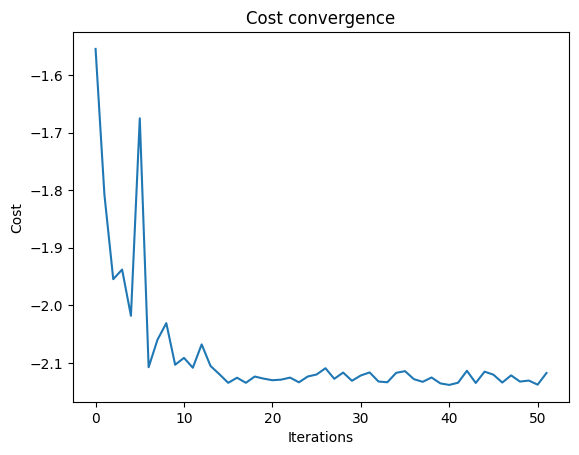

In [20]:
plt.plot(cost_trace)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Cost convergence")
plt.show()

In [ ]:
result.dataframe

,v,count,probability,bitstring
0,"[1, 0, 1, 1, 1]",218,0.106445,11101
1,"[1, 0, 1, 1, 0]",208,0.101562,01101
2,"[1, 1, 1, 1, 1]",164,0.080078,11111
3,"[0, 1, 1, 1, 1]",163,0.079590,11110
4,"[0, 1, 1, 1, 0]",144,0.070312,01110
5,"[1, 1, 1, 1, 0]",129,0.062988,01111
6,"[0, 1, 1, 0, 1]",126,0.061523,10110
7,"[1, 0, 1, 0, 1]",116,0.056641,10101
8,"[1, 1, 1, 0, 1]",82,0.040039,10111
9,"[1, 1, 0, 1, 1]",73,0.035645,11011
